In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge

try:
    from sklearn.experimental import enable_iterative_imputer
except:
    pass
from sklearn.impute import IterativeImputer, KNNImputer

from tsprial.forecasting import ForecastingCascade

import warnings
warnings.simplefilter("ignore")

In [2]:
### UTILITY FUNCTIONS TO SIMULATE TIME SERIES ###

def gen_sinusoidal(timesteps, amp, freq, noise):
    X = np.arange(timesteps)
    e = np.random.normal(0,noise, (timesteps,))
    y = amp*np.sin(X*(2*np.pi/freq))+e
    return y

def gen_randomwalk(timesteps, noise):
    y = np.random.normal(0,noise, (timesteps,))
    return y.cumsum()

def gen_step(timesteps, amp, freq):

    step = np.r_[np.repeat(np.arange(timesteps//24), 24),
                 np.ones(timesteps-timesteps//24*24)*timesteps//24] + (8-freq)
    step = ((step % 7) < 1).astype(int)

    return amp*step

def gen_ts(timesteps, amp, freq, noise, add_trend=True, add_steps=True, random_state=0):
    np.random.seed(random_state)

    if isinstance(freq, (int,float)):
        seas = gen_sinusoidal(timesteps=timesteps, amp=amp, freq=freq, noise=noise)
    elif np.iterable(freq) and not isinstance(freq, str):
        seas = np.zeros(timesteps)
        for f in freq:
            if isinstance(f, (int,float)):
                seas += \
                    gen_sinusoidal(timesteps=timesteps, amp=amp, freq=f, noise=noise)
            else:
                raise ValueError("freq not understood.")
    else:
        raise ValueError("freq not understood.")

    if add_steps:
        seas += gen_step(timesteps, freq=6, amp=-0.8*amp)
        seas += gen_step(timesteps, freq=7, amp=-1.2*amp)

    if add_trend:
        rw = gen_randomwalk(timesteps=timesteps, noise=1)
        X = np.linspace(0,10, timesteps).reshape(-1,1)
        X = np.power(X, [1,2])
        trend = LinearRegression().fit(X, rw).predict(X)
        return seas + trend

    return seas

Text(0.5, 0, 'hours')

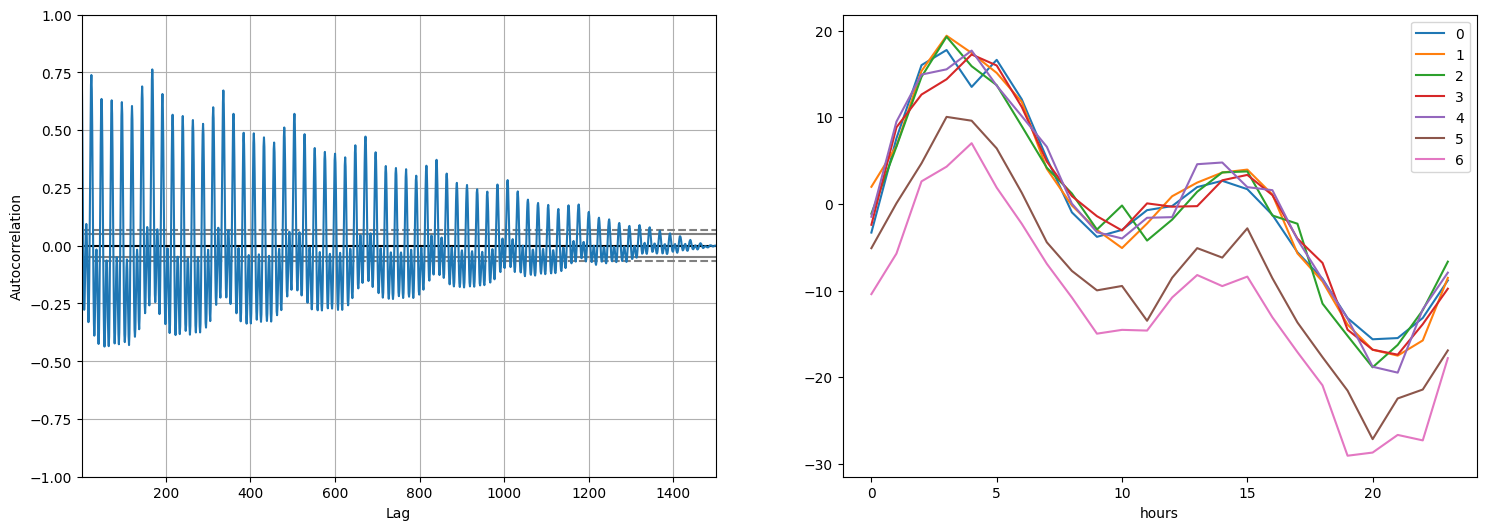

In [3]:
### SIMULATED TIME SERIES PATTERNS ###

timesteps = 1500

series = gen_ts(
    timesteps, add_trend=False,
    amp=10, freq=[12,24], noise=3,
    random_state=777
)

plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
pd.plotting.autocorrelation_plot(series)

plt.subplot(1,2,2)
pd.DataFrame(series).pivot_table(
    index=np.r_[np.tile(np.arange(0,24),timesteps//24),
                np.arange(0,timesteps-24*(timesteps//24))],
    columns=(np.r_[np.repeat(np.arange(timesteps//24), 24),
                   np.ones(timesteps-timesteps//24*24)*timesteps//24] % 7),
    aggfunc='mean'
).T.reset_index(drop=True).T.plot(ax=plt.gca())
plt.xlabel('hours')

In [4]:
### SIMULATE TIME SERIES ###

n_series, timesteps = 30, 1500

df = {}
for i in range(n_series):
    df[f'ts_{i}'] = gen_ts(
        timesteps, add_trend=True,
        amp=10, freq=[12,24], noise=4,
        random_state=i
    )
df = pd.DataFrame(
    df, index=pd.date_range(
    '2020-01-01', periods=timesteps, freq='H'
    )
)

df.shape

(1500, 30)

<AxesSubplot: >

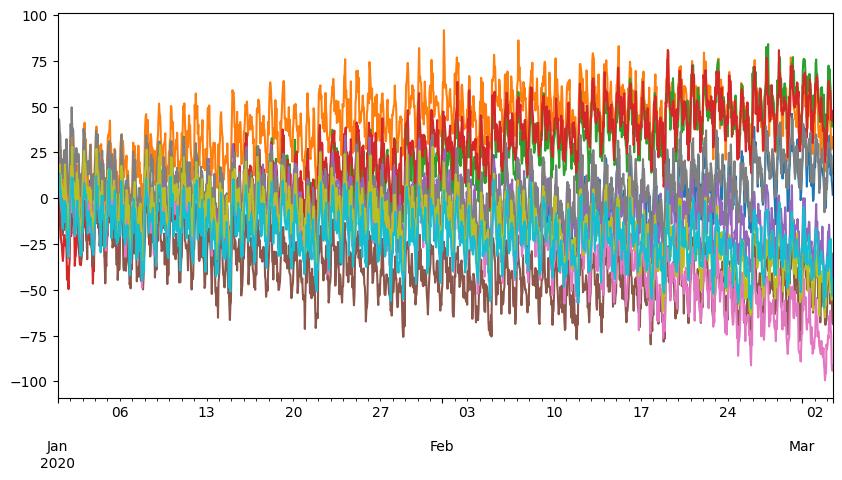

In [5]:
### PLOT SIMULATED TIME SERIES ###

df.sample(n=10, axis=1, random_state=33).plot(
    legend=False, figsize=(10,5))

### TRAIN TEST SPLIT

In [6]:
### TRAIN TEST SPLIT ###

y_train, y_test = train_test_split(df, test_size=24*7, shuffle=False)
y_train.shape, y_test.shape

((1332, 30), (168, 30))

### SIMULATE MISSING VALUE INTERVALS

In [7]:
### SIMULATE MISSING VALUE INTERVALS ###

np.random.seed(7777)

missing_lenghts = np.random.randint(24, 24*3, n_series)
missing_positions = np.random.randint(y_train.shape[0]-(24*3*2), y_train.shape[0]-(24*3+1), n_series)

missing_positions.shape, missing_lenghts.shape

((30,), (30,))

### INSERT MISSING INTERVAL INTO FIRST TIME SERIES

<AxesSubplot: >

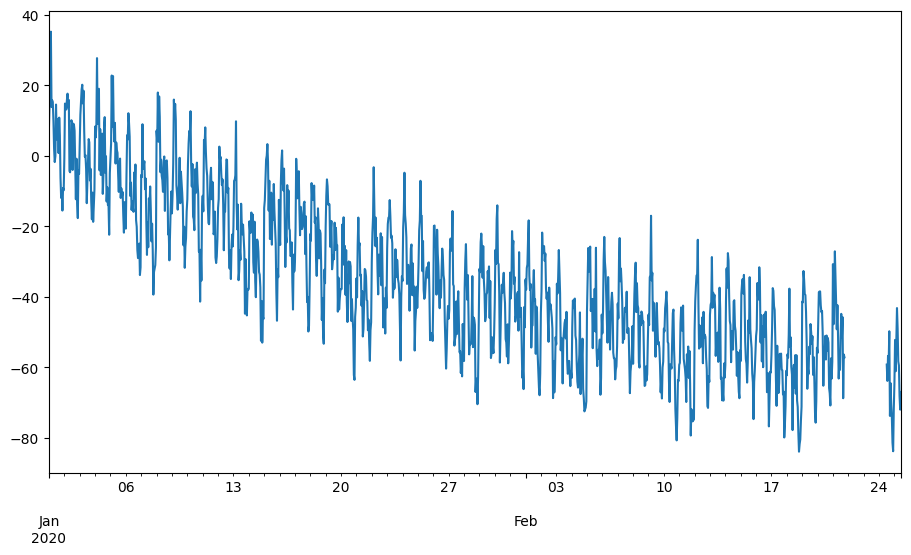

In [8]:
### INSERT MISSING INTERVAL INTO FIRST TIME SERIES ###

i = 2

ts_id = f'ts_{i}'
missing_ts = y_train[ts_id].copy()
missing_ts.iloc[missing_positions[i]:missing_positions[i]+missing_lenghts[i]] = np.nan

missing_ts.plot(figsize=(11,6))

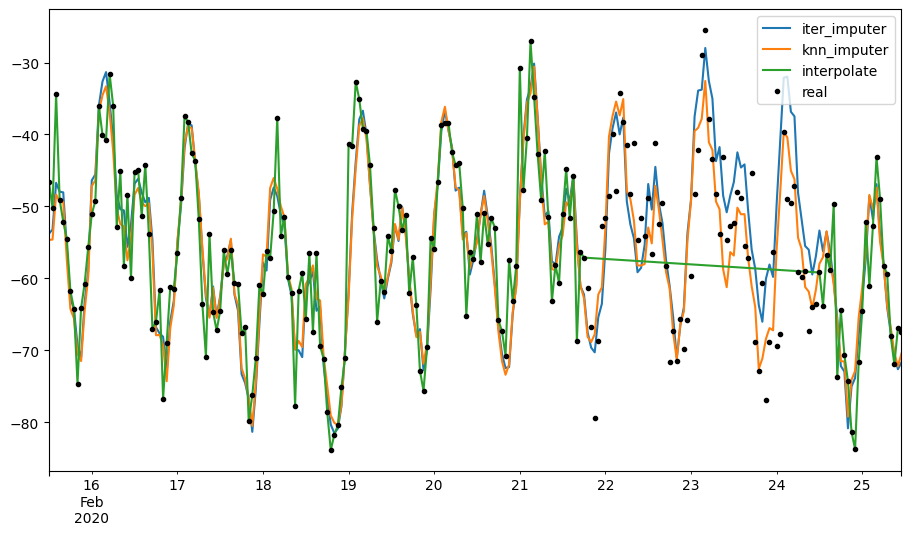

In [9]:
### COMPARE RECONSCRUCTION ABILITY ###

shift_df = pd.DataFrame({
    f"shift_{s}": missing_ts.shift(s) for s in range(1,24*7+1)
})

plt.figure(figsize=(11,6))

imp = IterativeImputer(Ridge(), max_iter=10, skip_complete=True)
tshift_df = imp.fit_transform(shift_df)

model = Ridge()
model.fit(tshift_df[~missing_ts.isna()], missing_ts.dropna())
pd.Series(model.predict(tshift_df),
          index=missing_ts.index, name='iter_imputer').tail(24*10).plot()

imp = KNNImputer()
tshift_df = imp.fit_transform(shift_df)

model = Ridge()
model.fit(tshift_df[~missing_ts.isna()], missing_ts.dropna())
pd.Series(model.predict(tshift_df),
          index=missing_ts.index, name='knn_imputer').tail(24*10).plot()

missing_ts.interpolate(limit_direction='both').tail(24*10).plot(label='interpolate')
y_train[ts_id].tail(24*10).plot(style='.k', label='real')
plt.legend()
plt.show()

### FORECAST WITH INTEPOLATION

In [10]:
### FORECAST WITH INTEPOLATION ###

model_interp = ForecastingCascade(
    Ridge(),
    lags=range(1,24*7+1),
    use_exog=False,
    accept_nan=False
)

model_interp.fit(None, missing_ts.interpolate(limit_direction='both'))

model_interp.score(np.arange(24*7), y_test[f"ts_{i}"], scoring='rmse')

9.285415719711551

### FORECAST WITH ITER IMPUTER

In [11]:
### FORECAST WITH ITER IMPUTER ###

model_iter = ForecastingCascade(
    make_pipeline(
        IterativeImputer(Ridge(), max_iter=10),
        Ridge()
    ),
    lags=range(1,24*7+1),
    use_exog=False,
    accept_nan=True
)

model_iter.fit(None, missing_ts)

model_iter.score(np.arange(24*7), y_test[f"ts_{i}"], scoring='rmse')

6.950279135186789

### FORECAST WITH KNN IMPUTER

In [12]:
### FORECAST WITH KNN IMPUTER ###

model_knn = ForecastingCascade(
    make_pipeline(
        KNNImputer(),
        Ridge()
    ),
    lags=range(1,24*7+1),
    use_exog=False,
    accept_nan=True
)

model_knn.fit(None, missing_ts)

model_knn.score(np.arange(24*7), y_test[f"ts_{i}"], scoring='rmse')

6.700753576501235

### PLOT FORECASTS COMPARISON

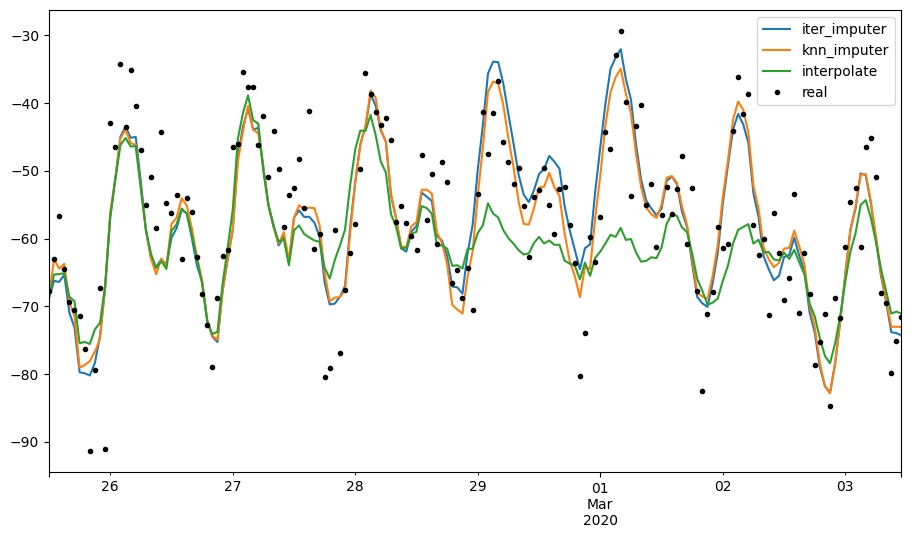

In [13]:
### PLOT FORECASTS COMPARISON ###

plt.figure(figsize=(11,6))
pd.Series(model_iter.predict(np.arange(24*7)), index=y_test.index, name='iter_imputer').plot()
pd.Series(model_knn.predict(np.arange(24*7)), index=y_test.index, name='knn_imputer').plot()
pd.Series(model_interp.predict(np.arange(24*7)), index=y_test.index, name='interpolate').plot()
y_test[ts_id].plot(style='.k', label='real')
plt.legend()
plt.show()

### FORECAST AND COMPARE IMPUTATION METHODS

In [14]:
### FORECAST AND COMPARE IMPUTATION METHODS ###

scores_interp = {'rmse':[],'mae':[]}
scores_fill = {'iter':{'rmse':[],'mae':[]},
               'knn':{'rmse':[],'mae':[]}}

for i,(l,idx) in tqdm(enumerate(zip(missing_lenghts, missing_positions)), total=n_series):

    missing_ts = y_train[f"ts_{i}"].copy()
    missing_ts.iloc[idx:idx+l] = np.nan

    model = ForecastingCascade(
        make_pipeline(
            IterativeImputer(Ridge(), max_iter=10),
            Ridge()
        ),
        lags=range(1,24*7+1),
        use_exog=False,
        accept_nan=True
    )
    model.fit(None, missing_ts)

    scores_fill['iter']['rmse'].append(
        model.score(np.arange(24*7), y_test[f"ts_{i}"], scoring='rmse')
    )
    scores_fill['iter']['mae'].append(
        model.score(np.arange(24*7), y_test[f"ts_{i}"], scoring='mae')
    )

    model = ForecastingCascade(
        make_pipeline(
            KNNImputer(),
            Ridge()
        ),
        lags=range(1,24*7+1),
        use_exog=False,
        accept_nan=True
    )
    model.fit(None, missing_ts)

    scores_fill['knn']['rmse'].append(
        model.score(np.arange(24*7), y_test[f"ts_{i}"], scoring='rmse')
    )
    scores_fill['knn']['mae'].append(
        model.score(np.arange(24*7), y_test[f"ts_{i}"], scoring='mae')
    )

    model = ForecastingCascade(
        Ridge(),
        lags=range(1,24*7+1),
        use_exog=False,
        accept_nan=False
    )
    model.fit(None, missing_ts.interpolate(limit_direction='both'))

    scores_interp['rmse'].append(
        model.score(np.arange(24*7), y_test[f"ts_{i}"], scoring='rmse')
    )
    scores_interp['mae'].append(
        model.score(np.arange(24*7), y_test[f"ts_{i}"], scoring='mae')
    )

100%|██████████| 30/30 [06:41<00:00, 13.37s/it]


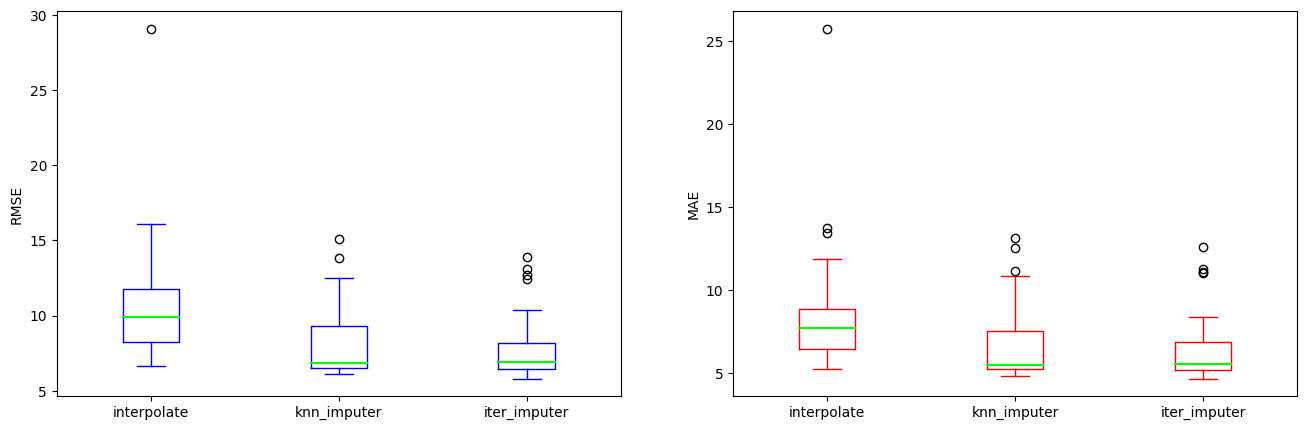

In [15]:
### PLOT ERROR SCORES ###

boxplotcolorprop = lambda c: {
    'medianprops':{'c':'lime', 'linewidth':1.5},
    'boxprops':{'c':c},
    'whiskerprops':{'c':c},
    'capprops':{'c':c}
}


plt.figure(figsize=(16,5))

plt.subplot(121)
pd.DataFrame({
    'interpolate': scores_interp['rmse'],
    'knn_imputer': scores_fill['knn']['rmse'],
    'iter_imputer': scores_fill['iter']['rmse']
}).plot.box(ax=plt.gca(), ylabel='RMSE', **boxplotcolorprop('blue'))

plt.subplot(122)
pd.DataFrame({
    'interpolate': scores_interp['mae'],
    'knn_imputer': scores_fill['knn']['mae'],
    'iter_imputer': scores_fill['iter']['mae']
}).plot.box(ax=plt.gca(), ylabel='MAE', **boxplotcolorprop('red'))

plt.show()